In [1]:
import pickle
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# import matplotlib.colors as mcolors

# from neurodsp import filt
# from neurodsp.spectral import compute_spectrum, rotate_powerlaw
# from neurodsp.plts.spectral import plot_power_spectra

# from scipy import signal

# from sklearn.decomposition import FastICA, PCA
# from sklearn.pipeline import Pipeline
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.model_selection import ShuffleSplit, cross_val_score
# from sklearn.preprocessing import StandardScaler

# from mne import Epochs, pick_types, events_from_annotations
# from mne.channels import make_standard_montage
# from mne.io import concatenate_raws, read_raw_edf
# from mne.datasets import eegbci
# from mne.decoding import CSP

# import seaborn as sns
# import mne
# import os

# import brainflow
# from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds

# from scipy.signal import butter, sosfiltfilt, sosfreqz 
# import matplotlib.patches as patches

# import time
import pyeeg

import tools

In [2]:
Pkl_Filename = '../data/raw_data_recording-8ch-3.pkl'
data_from_file = []
with open(Pkl_Filename, 'rb') as file:
    data_from_file = pickle.load(file)
    
channels = ['T3', 'F7', 'Fp1', 'Fp2', 'F8', 'F4', 'F3', 'T4'] # Data set 3

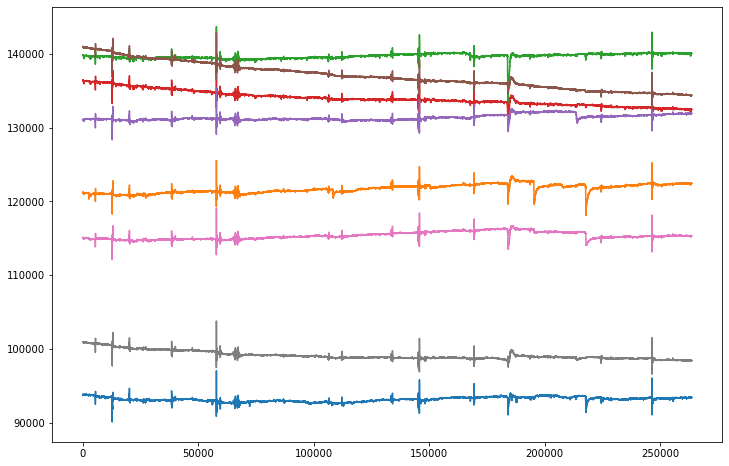

In [3]:
sorted_data = tools.assemble_sort_raw_data(data_from_file)
event_list = tools.get_event_list(sorted_data, ignored=[9])
ch_sel = list(range(1,9))
t_sel = [22]

tools.plot_all_channels(sorted_data[ch_sel])

#### No need for scaling as brainflow returns uV

/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/filter.py:96: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/checks.py:172: UserWarning: Transition bandwidth is  40.2  Hz. This is greater than the desiredpass/stop bandwidth of  29.0 Hz
  warn('Transition bandwidth is  {:.1f}  Hz. This is greater than the desired'\


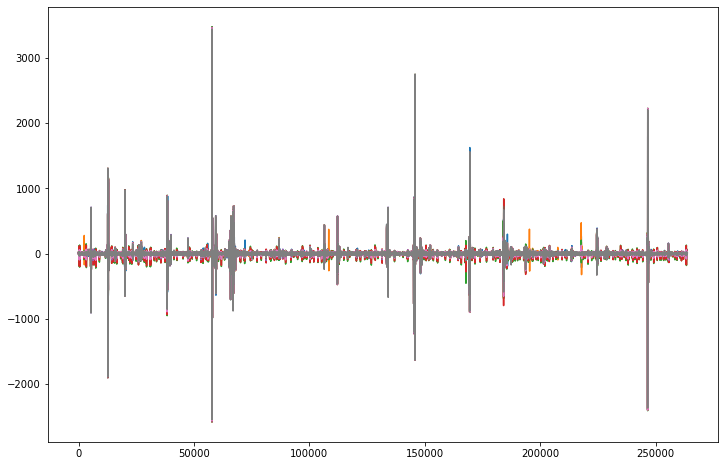

In [4]:
ch_data = tools.filter_eeg(sorted_data[ch_sel], 250, (1,30))
tools.plot_all_channels(ch_data)

### Haha! I sneezed during the recording, can you see where?
After some searching, the sneeze happened on the 78th regular event. `i=77` after removing blink events.<br>
With blink events, `i=78`

In [5]:
# close up of eye blinks
# plot_all_channels(ch_data[:,200:800])
# plot_all_channels(ch_data[:,-675:-90])

In [6]:
# after a visual look over, 3 events seem worth removing
# the sneeze and two others that were probably head movement.
sneeze = 77
bad_events = [59, sneeze, 107]
good_events =  [i for i in range(len(event_list[1:-1])) if i not in bad_events]

fs = 250
dt = 1000/fs
sdt = np.round(dt).astype(int) # should be 4ms/dt
baseline_duration = int(100 / sdt) # ms
erp_start = int(200 / sdt)
erp_end = int(500 / sdt)
duration = int(2000 / sdt)
total = baseline_duration + duration
lin_time = np.linspace(-100,2000, total)

epoched_data = []
for ev in event_list:
    # every event except blink events
    if ev[2] != 5:
        event_time = int(ev[0] * fs)
        start = event_time - baseline_duration
        stop = event_time + duration
        data = np.array(ch_data[:, start:stop])
        data = data.T - np.mean(data.T, 0)
        data = data - np.mean(data[:baseline_duration, :], 0)
        epoched_data.append(data.T)
        
events = np.array(event_list[1:-1]) # skip blink events
events[:,0] = events[:,0] * fs
events = events.astype(int)

events = events[good_events]
epoched_data = [epoched_data[i] for i in good_events]

Number of mental "Hey Brain" instances: 35
Number of verbal "Hey Brain" instances: 32
Number of epochs: 137


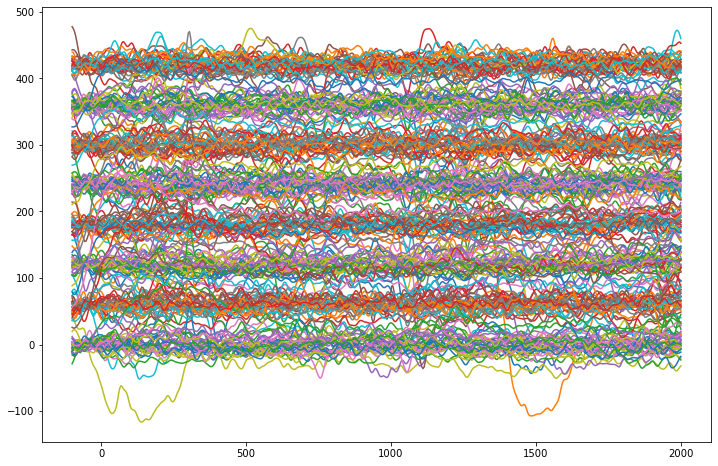

In [7]:
epochs = np.array(epoched_data)
think = epochs[np.where(events[:,2] == 2)]
say = epochs[np.where(events[:,2] == 1)]
figure(figsize=(12,8))
for ep in think:
    i = 0
    for ch in ep:
        plt.plot(lin_time, ch + (i*60))
        i += 1
        
print('Number of mental "Hey Brain" instances:', len(think))
print('Number of verbal "Hey Brain" instances:', len(say))
print('Number of epochs:', len(epochs))

### Feature Establishing

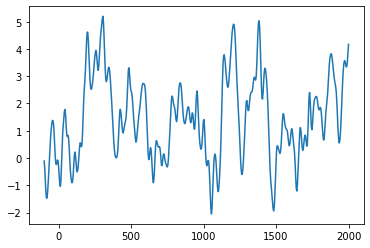

In [8]:
avg_think = np.mean(think,0)
plt.plot(lin_time, np.mean(avg_think,0))

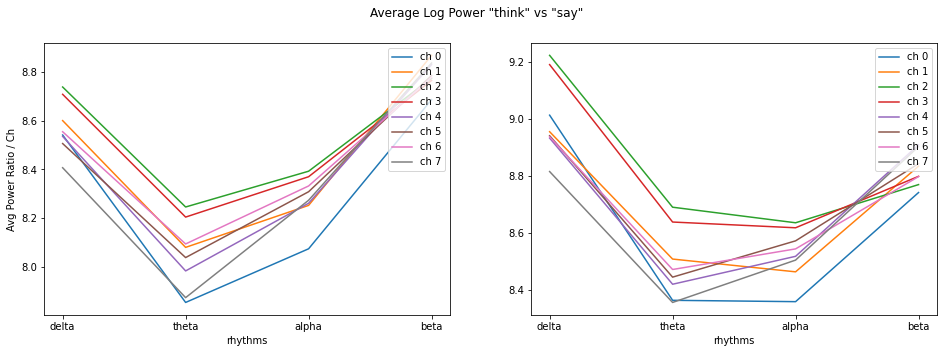

In [26]:
binning = [1, 4, 7, 12, 30]
rhythms = ['delta', 'theta', 'alpha', 'beta']

def get_log_powers(segment_data, bins=[], fs=250):
    """Get the powers associated with each channel
        during a segment of data
    """
    chs_pwr = []
    for ch in segment_data:
        power, _ = pyeeg.bin_power(ch, bins, fs)
        chs_pwr.append(np.log(power))
        
    return chs_pwr

def avg_power_per_ch(ev_epochs, bins=[], fs=250):
    """Gets the power for each channel in each
        epoch. Then averages the power across all
        epochs, returning the channel average for all epochs.
    """
    all_pwr = []
    for epoch in ev_epochs:
        epoch_pwr = get_log_powers(epoch, bins, fs)
        all_pwr.append(epoch_pwr)

    all_pwr = np.array(all_pwr)
    ch_avg = np.mean(all_pwr[:,:], 0)
    
    return ch_avg
        
think_pwr_avg = avg_power_per_ch(think, binning, fs)
say_pwr_avg = avg_power_per_ch(say, binning, fs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Average Log Power "think" vs "say"')

for i, values in enumerate(think_pwr_avg):
    name = 'ch ' + str(i)
    ax1.plot(rhythms, values, label=name)
    
ax1.set_xlabel('rhythms')
ax1.set_ylabel('Avg Power Ratio / Ch')
# ax1.title('Avg Power Ratio across "think" epochs')
ax1.legend(loc='upper right')

for i, values in enumerate(say_pwr_avg):
    name = 'ch ' + str(i)
    ax2.plot(rhythms, values, label=name)
    
ax2.set_xlabel('rhythms')
# ax2.title('Avg Power Ratio across "say" epochs')
ax2.legend(loc='upper right')


### CSP attempt